# NNDL Extra - Q2

# Install Packages

In [2]:
!pip install googletrans==3.1.0a0
!pip install hazm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=0aae45b1718df612b3392a8650b9054294aba0c6e832004c2ff7aeaef9a96141
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      

# Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
import time
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed


import re
import emoji
from hazm import Normalizer, Stemmer, word_tokenize, stopwords_list
from transformers import AutoTokenizer
from transformers import AutoModel
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


2024-06-30 13:48:52.673454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 13:48:52.673560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 13:48:52.813502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

### Load Dataset From Uploaded Files

In [64]:
original = pd.read_csv('/kaggle/input/deepsentipers/original.csv', names=['comment', 'label'])
test = pd.read_csv('/kaggle/input/deepsentipers/test.csv', names=['comment', 'label'])

In [69]:
original.head()

,comment,label
0,گوشي خوبيه(قوي و شکيل و زيبا و بي رقيب)البته ت...,1
1,سلام خيلي خوبه بخرين.,2
2,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0
3,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0
4,من حدوداً ۱ ماهي‌ که مي‌شه اين گوشي رو دارم، ر...,1


In [72]:
len_data = len(test) + len(original)
print("Number of data in the dataset:", len_data)

Number of data in the dataset: 7415


In [6]:
labels = original['label'].unique()
print(labels)

[ 1  2  0 -1 -2]


# Preprocessing

## Map Labels

In [75]:
def map_labels(label):
    if label in [-2, -1]:
        return -1
    elif label in [1, 2]:
        return 1
    else:
        return 0

In [76]:
original['label'] = original['label'].apply(map_labels)
test['label'] = test['label'].apply(map_labels)

In [77]:
labels = original['label'].unique()
print(labels)

[ 1  0 -1]


## Distribution of labels 

In [10]:
counts = original['label'].value_counts()
print(counts)

label
 1    2611
 0    2409
-1     541
Name: count, dtype: int64


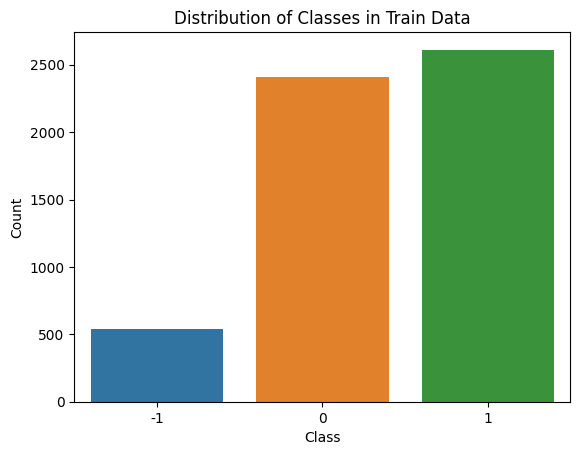

In [11]:
sns.countplot(x='label', data=original)
plt.title('Distribution of Classes in Train Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

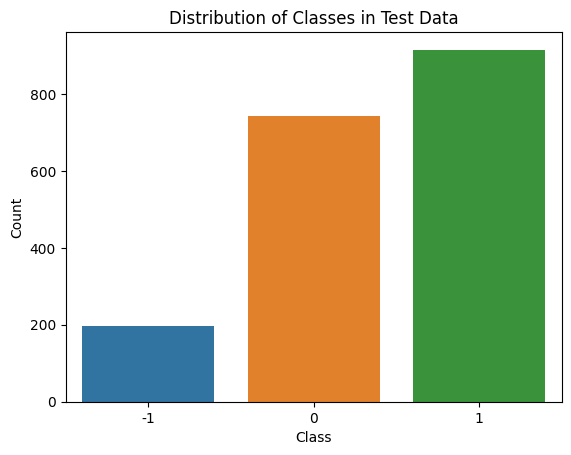

In [79]:
sns.countplot(x='label', data=test)
plt.title('Distribution of Classes in Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Number of Tokens

In [81]:
token_counts = original['comment'].apply(lambda x: len(x.split()))
token_stats = token_counts.describe()
print(token_stats)

count    5561.000000
mean       21.919259
std        20.431711
min         1.000000
25%        11.000000
50%        18.000000
75%        27.000000
max       338.000000
Name: comment, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


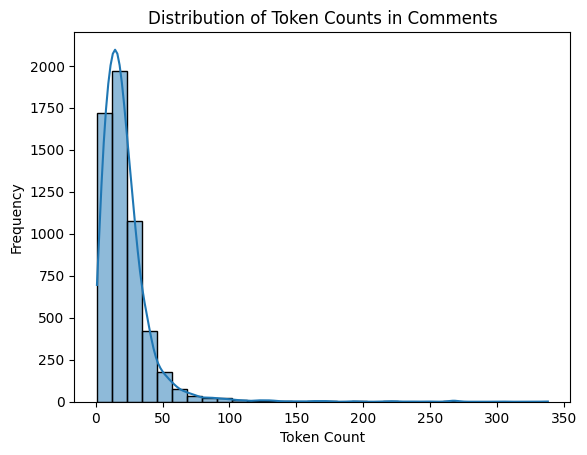

In [82]:
sns.histplot(token_counts, bins=30, kde=True)
plt.title('Distribution of Token Counts in Comments')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

### Removing Repetitive Characters

In [12]:
def remove_repetitive_chars(text):
    return re.sub(r'(.)\1+', r'\1', text)

example_text = "خووووووب"
print("Before:", example_text)
print("After:", remove_repetitive_chars(example_text))

Before: خووووووب
After: خوب


### Incorrect Spellings (Using Hazm Normalizer)

In [20]:
normalizer = Normalizer()

def correct_spelling(text):
    return normalizer.normalize(text)

example_text = "جمعهها مطالعه کنید"
print("Before:", example_text)
print("After:", correct_spelling(example_text))

Before: جمعهها مطالعه کنید
After: جمعه‌ها مطالعه کنید


In [14]:
def preprocess_text(text):
    text = remove_repetitive_chars(text)
    text = correct_spelling(text)
    return text

In [15]:
tqdm.pandas()
original['comment'] = original['comment'].progress_apply(preprocess_text)

  0%|          | 0/5561 [00:00<?, ?it/s]

In [38]:
tqdm.pandas()
test['comment'] = test['comment'].progress_apply(preprocess_text)

  0%|          | 0/1854 [00:00<?, ?it/s]

In [16]:
original.head()

,comment,label
0,گوشی خوبیه (قوی و شکیل و زیبا و بی‌رقیب) البته...,1
1,سلام خیلی خوبه بخرین.,1
2,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0
3,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ت...,0
4,من حدودا ۱ ماهی که می‌شه این گوشی رو دارم، راض...,1


# Back translation

In [17]:
def back_translate(text, src_lang='fa', target_lang='en'):
    try:
        translated = translator.translate(text, src=src_lang, dest=target_lang).text
        back_translated = translator.translate(translated, src=target_lang, dest=src_lang).text
        return back_translated
    except Exception as e:
        print(f"Error: {e}")
        return text  

In [18]:
translator = Translator()

In [19]:
original['back_translated_comment'] = original['comment'].progress_apply(back_translate)

  0%|          | 0/5561 [00:00<?, ?it/s]

## Display the original and back-translated

In [21]:
for original, back_translated in zip(original['comment'].head(10), original['back_translated_comment'].head(10)):
    print(f"Original: {original}")
    print(f"Back-Translated: {back_translated}")
    print("-" * 50)

Original: گوشی خوبیه (قوی و شکیل و زیبا و بی‌رقیب) البته تو تیپ وگروه خودش عالیه!
Back-Translated: گوشی خوبیه (قوی، شیک، زیبا و بی رقیب) البته در رده خودش عالیه!
--------------------------------------------------
Original: سلام خیلی خوبه بخرین.
Back-Translated: سلام خیلی خوب بخر
--------------------------------------------------
Original: از جمله قابلیت‌های ارتباطی HTC Desire SV می‌توان به پشتیبانی از Wi-Fi، GPRS، ۳ G اشاره کرد که برقراری ارتباط با اینترنت را به سهولت فراهم می‌کند.
Back-Translated: از قابلیت های ارتباطی HTC Desire SV می توان به پشتیبانی از Wi-Fi، GPRS، 3G اشاره کرد که ارتباط آسان با اینترنت را فراهم می کند.
--------------------------------------------------
Original: نهایتا، یک دوربین VGA نیز برای انجام مکالمات تصویری در قسمت جلوی گوشی تعبیه گردیده است.
Back-Translated: در نهایت یک دوربین VGA نیز در جلوی گوشی برای مکالمات تصویری تعبیه شده است.
--------------------------------------------------
Original: من حدودا ۱ ماهی که می‌شه این گوشی رو دارم، راضی هم هستم، در مورد د

### Create and Save New Datasets

In [22]:
original_data = original[['comment', 'label']].copy()
back_translated_data = original[['back_translated_comment', 'label']].rename(columns={'back_translated_comment': 'comment'})

In [47]:
augmented_data = pd.concat([original_data, back_translated_data], ignore_index=True)

### Save preprocessed data for next part

In [42]:
original_data.to_csv('/kaggle/working/train_data.csv', index=False)
test.to_csv('/kaggle/working/test_data.csv', index=False)
augmented_data.to_csv('/kaggle/working/augmented_data.csv', index=False)

# Fine Tune FaBert

### Load preprocessed data from last part

In [29]:
augmented_data = pd.read_csv('/kaggle/input/deepsentipers/augmented_data.csv')
train_data = pd.read_csv('/kaggle/input/deepsentipers/train_data.csv')
test_data = pd.read_csv('/kaggle/input/deepsentipers/test_data.csv')

In [30]:
label_mapping = {-1: 0, 0: 1, 1: 2}

train_data['label'] = train_data['label'].map(label_mapping)
test_data['label'] = test_data['label'].map(label_mapping)
augmented_data['label'] = augmented_data['label'].map(label_mapping)

### Create Valid Dataset - 30% of Test Data

In [32]:
valid_data, test_data = train_test_split(test_data, test_size=0.7, random_state=42)

In [33]:
len_augmented_data = len(augmented_data)
len_train_data = len(train_data)
len_valid_data = len(valid_data)
len_test_data = len(test_data)

print(f"Length of Augmented Training Data: {len_augmented_data}")
print(f"Length of Original Training Data: {len_train_data}")
print(f"Length of Validation Data: {len_valid_data}")
print(f"Length of Test Data: {len_test_data}")

Length of Augmented Training Data: 11122
Length of Original Training Data: 5561
Length of Validation Data: 556
Length of Test Data: 1298


## Preprocessing For Sentiment 

In [34]:
def remove_repetitive_chars(text):
    return re.sub(r'(.)\1+', r'\1', text)

stopwords_persian = stopwords_list()
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_persian]
    return ' '.join(tokens)

stemmer = Stemmer()
def stem_text(text):
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

normalizer = Normalizer()

def correct_spelling(text):
    return normalizer.normalize(text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def handle_numbers(text):
    return re.sub(r'\d+', '', text)

def handle_negations(text):
    text = re.sub(r'\b(نیست|نمی|نه)\b', 'نه ', text)
    return text

def lowercasing(text):
    return text.lower()

In [35]:
def preprocess_text(text):
    text = lowercasing(text)
    text = remove_repetitive_chars(text)
    text = correct_spelling(text)
    text = handle_numbers(text)
    text = handle_negations(text)
    return text

In [36]:
tqdm.pandas()

augmented_data['comment'] = augmented_data['comment'].progress_apply(preprocess_text)
train_data['comment'] = train_data['comment'].progress_apply(preprocess_text)
valid_data['comment'] = valid_data['comment'].progress_apply(preprocess_text)
test_data['comment'] = test_data['comment'].progress_apply(preprocess_text)

  0%|          | 0/11122 [00:00<?, ?it/s]

  0%|          | 0/5561 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/1298 [00:00<?, ?it/s]

## Load FaBert Tokenizer and Model

In [19]:
tokenizer = BertTokenizer.from_pretrained("sbunlp/fabert")
model_org = AutoModelForSequenceClassification.from_pretrained('sbunlp/fabert', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/552k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sbunlp/fabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model_org

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Tokenize

In [37]:
def tokenize_function(examples):
    return tokenizer(examples['comment'], truncation=True, padding=True, max_length=128)

In [38]:
train_dataset = Dataset.from_pandas(train_data)
augmented_dataset = Dataset.from_pandas(augmented_data)
valid_dataset = Dataset.from_pandas(valid_data)
test_dataset = Dataset.from_pandas(test_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
augmented_dataset = augmented_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5561 [00:00<?, ? examples/s]

Map:   0%|          | 0/11122 [00:00<?, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]

Map:   0%|          | 0/1298 [00:00<?, ? examples/s]

##  PyTorch format

In [39]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
augmented_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print(train_dataset[0])

{'label': tensor(2), 'input_ids': tensor([  101,  5024, 15597,   111,  5265,   622, 32330,   622,  3808,   622,
        28570,  3141,   112,  2983,  2333,  8523, 47426,  3120, 14594,   104,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

# Train

In [40]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    learning_rate= 10e-5,
    num_train_epochs=5,              
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=16,    
    weight_decay= 0,
    warmup_ratio = 0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to=[],  
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

## Train on Original Data

In [26]:
for param in model_org.bert.parameters():
    param.requires_grad = False

for param in model_org.bert.encoder.layer[-1:].parameters():
    param.requires_grad = True

for param in model_org.classifier.parameters():
    param.requires_grad = True

In [27]:
trainer_org = Trainer(
    model=model_org,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [28]:
trainer_org.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.524230,0.767986,0.732557,0.701849,0.767986
2,0.679800,0.472566,0.807554,0.808153,0.808859,0.807554
3,0.500200,0.466837,0.812950,0.812416,0.812949,0.812950
4,0.500200,0.486477,0.811151,0.809333,0.811389,0.811151
5,0.426100,0.470390,0.823741,0.823217,0.823247,0.823741


TrainOutput(global_step=1740, training_loss=0.5187254982433099, metrics={'train_runtime': 155.2231, 'train_samples_per_second': 179.129, 'train_steps_per_second': 11.21, 'total_flos': 1828967144981760.0, 'train_loss': 0.5187254982433099, 'epoch': 5.0})

## Train on Augmented Data

In [41]:
model_aug = AutoModelForSequenceClassification.from_pretrained('sbunlp/fabert', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sbunlp/fabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
for param in model_aug.bert.parameters():
    param.requires_grad = False

for param in model_aug.bert.encoder.layer[-1:].parameters():
    param.requires_grad = True

for param in model_aug.classifier.parameters():
    param.requires_grad = True

In [43]:
trainer_aug = Trainer(
    model=model_aug,
    args=training_args,
    train_dataset=augmented_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [44]:
trainer_aug.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.650700,0.404164,0.843525,0.846584,0.854010,0.843525
2,0.478000,0.365991,0.863309,0.862979,0.863509,0.863309
3,0.371300,0.380872,0.857914,0.857218,0.856776,0.857914
4,0.332300,0.391883,0.852518,0.852811,0.853182,0.852518
5,0.300900,0.410125,0.857914,0.858961,0.862358,0.857914


TrainOutput(global_step=3480, training_loss=0.40801865588659525, metrics={'train_runtime': 291.9012, 'train_samples_per_second': 190.51, 'train_steps_per_second': 11.922, 'total_flos': 3657934289963520.0, 'train_loss': 0.40801865588659525, 'epoch': 5.0})

## Store Accuracy and Loss per epoch

In [48]:
def extract_metrics(logs):
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]
    return {'eval_loss': eval_loss, 'eval_accuracy': eval_accuracy}

In [50]:
org_metrics = extract_metrics(original_logs)
aug_metrics = extract_metrics(aug_logs)
org_df = pd.DataFrame(org_metrics)
aug_df = pd.DataFrame(aug_metrics)

In [83]:
org_df

,eval_loss,eval_accuracy
0,0.524230,0.767986
1,0.472566,0.807554
2,0.466837,0.812950
3,0.486477,0.811151
4,0.470390,0.823741


In [52]:
org_df.to_csv('/kaggle/working/original_model_metrics.csv', index=False)
aug_df.to_csv('/kaggle/working/augmented_model_metrics.csv', index=False)

## Evaluate the Models

In [237]:
original_results_valid = trainer_org.evaluate()
original_results_test = trainer_org.evaluate(test_dataset)
print("Original Model Validation Results:", original_results_valid)
print("Original Model Test Results:", original_results_test)

Original Model Validation Results: {'eval_loss': 0.503380298614502, 'eval_accuracy': 0.802158273381295, 'eval_f1': 0.8010631270720775, 'eval_precision': 0.8003088438340237, 'eval_recall': 0.802158273381295, 'eval_runtime': 2.1261, 'eval_samples_per_second': 261.506, 'eval_steps_per_second': 16.462, 'epoch': 5.0}
Original Model Test Results: {'eval_loss': 0.500796914100647, 'eval_accuracy': 0.7989214175654854, 'eval_f1': 0.7999792542258309, 'eval_precision': 0.8028718288095522, 'eval_recall': 0.7989214175654854, 'eval_runtime': 4.8665, 'eval_samples_per_second': 266.723, 'eval_steps_per_second': 16.85, 'epoch': 5.0}


In [219]:
aug_results_valid = trainer_aug.evaluate()
aug_results_test = trainer_aug.evaluate(test_dataset)
print("Augmented Model Validation Results:", aug_results_valid)
print("Augmented Model Test Results:", aug_results_test)

Augmented Model Validation Results: {'eval_loss': 0.36599093675613403, 'eval_accuracy': 0.8633093525179856, 'eval_f1': 0.8629792700555827, 'eval_precision': 0.8635090197903785, 'eval_recall': 0.8633093525179856, 'eval_runtime': 2.0773, 'eval_samples_per_second': 267.66, 'eval_steps_per_second': 16.849, 'epoch': 5.0}
Augmented Model Test Results: {'eval_loss': 0.4350147247314453, 'eval_accuracy': 0.8312788906009245, 'eval_f1': 0.8301673714016445, 'eval_precision': 0.8300712568483881, 'eval_recall': 0.8312788906009245, 'eval_runtime': 4.8886, 'eval_samples_per_second': 265.513, 'eval_steps_per_second': 16.774, 'epoch': 5.0}


## Plot

In [54]:
def plot_epoch_loss(org_metrics, aug_metrics, title):
    epochs = range(1, len(org_metrics['eval_loss']) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, org_metrics['eval_loss'], label='Original Model Loss', linestyle='--', color='red')
    
    plt.plot(epochs, aug_metrics['eval_loss'], label='Augmented Model Loss', color='blue')
    
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_epoch_accuracy(org_metrics, aug_metrics, title):
    epochs = range(1, len(org_metrics['eval_accuracy']) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, org_metrics['eval_accuracy'], label='Original Model Accuracy', linestyle='--', color='blue')
    
    plt.plot(epochs, aug_metrics['eval_accuracy'], label='Augmented Model Accuracy', color='blue')
    
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


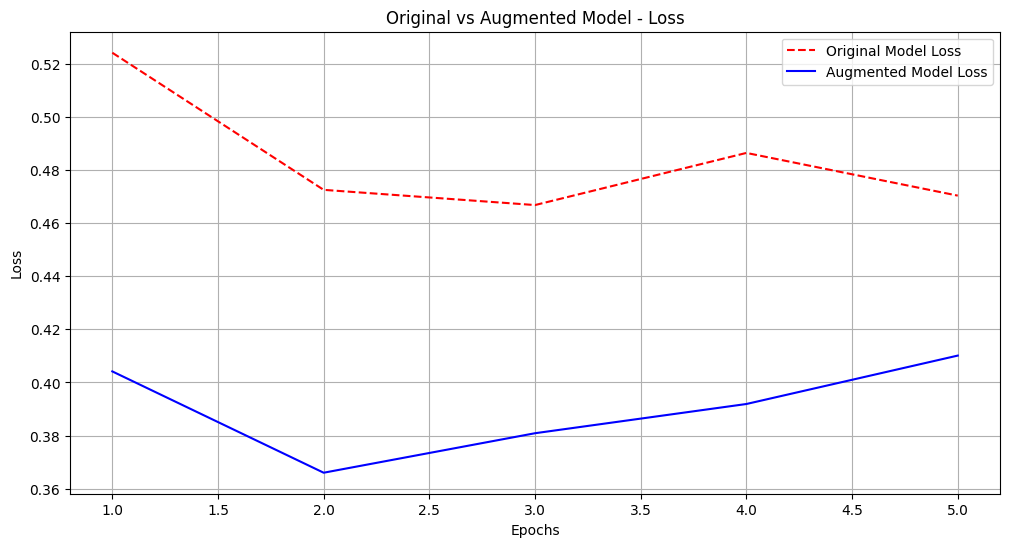

In [58]:
plot_epoch_loss(org_metrics, aug_metrics, 'Original vs Augmented Model')

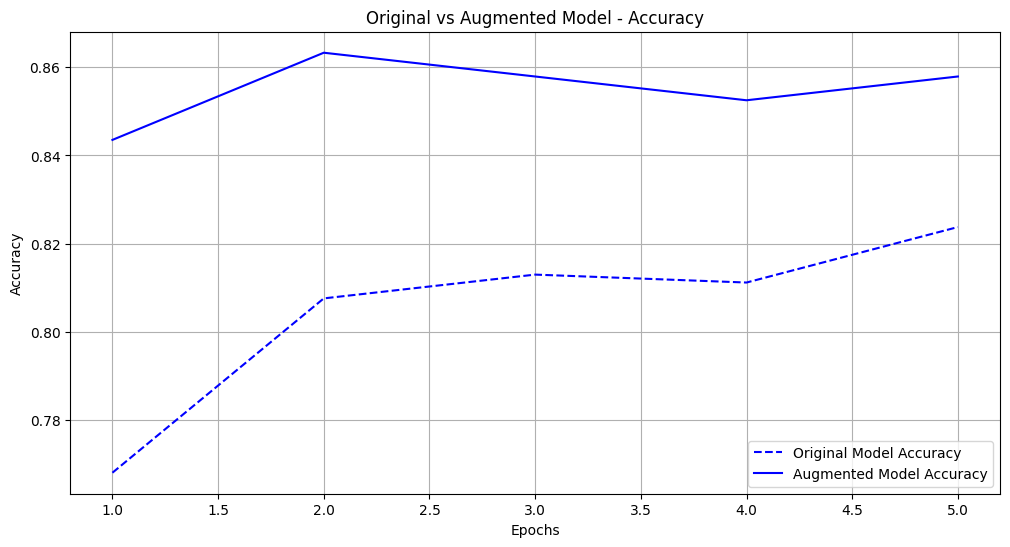

In [59]:
plot_epoch_accuracy(org_metrics, aug_metrics, 'Original vs Augmented Model')

## Confusion Matrix and Classification Report


In [60]:
def plot_confusion_matrix(cm, label_names, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def evaluate_model(trainer, dataset, label_names, title):
    predictions, labels, _ = trainer.predict(dataset)
    preds = np.argmax(predictions, axis=1)
    cm = confusion_matrix(labels, preds)
    cr = classification_report(labels, preds, target_names=label_names)
    plot_confusion_matrix(cm, label_names, title)
    return cm, cr

label_names = ['negative', 'neutral', 'positive']

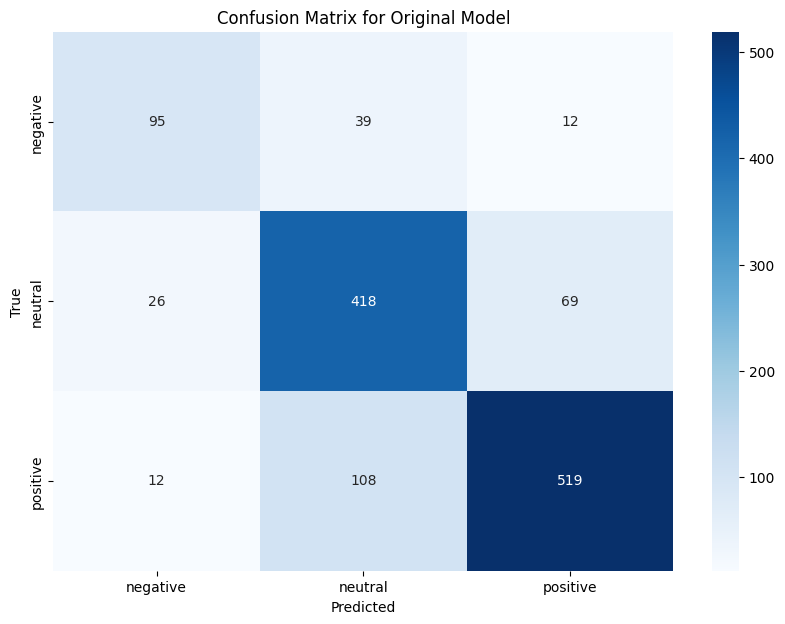

Original Dataset Confusion Matrix:
 [[ 95  39  12]
 [ 26 418  69]
 [ 12 108 519]]
Original Dataset Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.65      0.68       146
     neutral       0.74      0.81      0.78       513
    positive       0.86      0.81      0.84       639

    accuracy                           0.80      1298
   macro avg       0.77      0.76      0.76      1298
weighted avg       0.80      0.80      0.80      1298



In [61]:
original_cm, org_cr = evaluate_model(trainer_org, test_dataset, label_names, "Confusion Matrix for Original Model")
print("Original Dataset Confusion Matrix:\n", original_cm)
print("Original Dataset Classification Report:\n", org_cr)

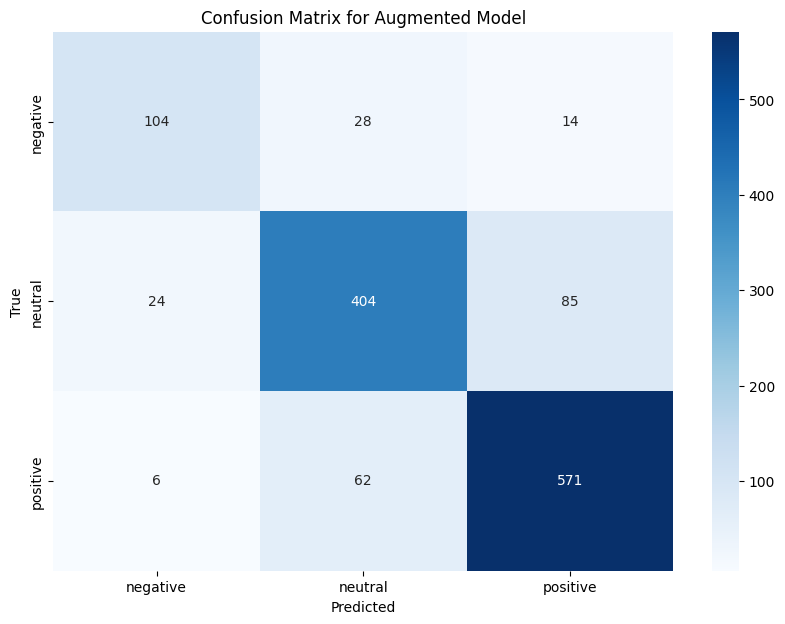

Augmented Dataset Confusion Matrix:
 [[104  28  14]
 [ 24 404  85]
 [  6  62 571]]
Augmented Dataset Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.71      0.74       146
     neutral       0.82      0.79      0.80       513
    positive       0.85      0.89      0.87       639

    accuracy                           0.83      1298
   macro avg       0.82      0.80      0.81      1298
weighted avg       0.83      0.83      0.83      1298



In [62]:
aug_cm, aug_cr = evaluate_model(trainer_aug, test_dataset, label_names, "Confusion Matrix for Augmented Model")
print("Augmented Dataset Confusion Matrix:\n", aug_cm)
print("Augmented Dataset Classification Report:\n", aug_cr)

## Misclassified Examples


In [63]:
def display_misclassified(trainer, dataset, original_data):
    label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}
    
    predictions, labels, _ = trainer.predict(dataset)
    preds = np.argmax(predictions, axis=1)
    misclassified = np.where(preds != labels)[0]
    
    for idx in misclassified[5:10]:  # changed to [-5:0] to print augmented
        original_idx = original_data.index[idx]
        print(f"Text: {original_data.loc[original_idx, 'comment']}")
        print(f"True Label: {label_names[labels[idx]]}, Predicted Label: {label_names[preds[idx]]}")
        print()

In [235]:
print("Original Dataset Misclassified Examples:")
display_misclassified(trainer_org, test_dataset, test_data)

Original Dataset Misclassified Examples:


Text: اگه دیجی کالا بیاره حتما نفر اول خودم می‌خرم!
True Label: positive, Predicted Label: neutral

Text: مثلا به راحتی می‌توانید بوسیله‌ی تجهیزات استقرار مختلف؛ دوربین را به دسته‌ی دوچرخه‌ی خود، به سطح جلوی یک اسکیت برد، به یک‌تخته‌ی موج‌سواری، میله‌های کایت و یا حتی مچ و یا سینه‌ی خود متصل کنید.
True Label: positive, Predicted Label: neutral

Text: که در حال حاضر این مشکل در ورژنها جدید برطرف شده است!
True Label: positive, Predicted Label: neutral

Text: در کل اگر می‌خواید یک دستگاه به‌روز رو داشته باشید تا بتونید بازی‌های روز جهان رو با اون بازی کنید من  درصد این کنسول رو پیشنهاد می‌کنم.
True Label: positive, Predicted Label: neutral

Text: کیفیت صدا: کیفیت صدا‌ی هر دو عالیه ولی tf  t به نظر من مقداری صدایش بلند‌تر است ولی اصلا محسوس نه  و اختلاف خیلی کمه ولی کیفیت صدا در ایپد کمی بهتره.
True Label: negative, Predicted Label: positive



In [233]:
print("Augmented Dataset Misclassified Examples:")
display_misclassified(trainer_aug, test_dataset, test_data)

Augmented Dataset Misclassified Examples:


Text: اگر بزرگنمای اپتیکال یه کم بالاتر بود گزینه بسیار مناسبی بود
True Label: positive, Predicted Label: neutral

Text: hd r  می‌تواند با کیفیت  p ful hd در فرمت avchd و با صدای استریو dolby digital فیلم‌برداری کند.
True Label: positive, Predicted Label: neutral

Text: باتری این گوشی یک باتری  میلی‌متری آمپر ساعتیست که از باتری مدل‌های  و  بسیار ضعیف‌تر است، با این حال بیش از  ساعت مکالمه متد را پشتیبانی می‌نماید.
True Label: negative, Predicted Label: neutral

Text: گوشی motorola razr m با وجود ابعاد بسیار کوچک‌تر یعنی  ×  میلی‌متر، صفحه نمایشی با اندازه یکسان با این گوشی دارد، و این نکته ایست که باعث میگرد به این نتیجه برسیم که htc در طراحی این گوشی، یک عقب‌گرد داشته است، حتی به نسبت گوشی سه سال پیش خود یعنی hd .
True Label: negative, Predicted Label: neutral

Text: (یعنی  گرم سبک‌تر از ipad ) • صفحه نمایش و بلندگوهاگوشی padfone  دارای یک صفحه نمایش عریض  ٫  اینچی از نوع super ips+ lcd بوده و از تکنولوژی igzo کمپانی شارپ نیز بهره می‌برد که طبق ادعای این کمپانی، انرژی کمتری مصرف کرده